In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,make_scorer, recall_score,accuracy_score,roc_auc_score,f1_score,precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from dask.distributed import Client
from dask_ml.model_selection import GridSearchCV
from xgboost import XGBClassifier
from xgboost.dask import DaskXGBClassifier
from sklearn.ensemble import IsolationForest
import dask.dataframe as dd
import dask
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ParameterGrid
from dask import delayed
from sklearn.model_selection import GridSearchCV as skGridSearchCV
import joblib
from matplotlib import font_manager

In [2]:
data = pd.read_excel('scoring.xlsx')
data

,CUSNO,CntCust,Group Sale,คำนำหน้า,อาชีพ,ปีที่เกิด,ที่อยู่_จังหวัด,เบอร์โทร_มี_ไม่มี,IDENT_Flag,running,...,sumpayafterbuy,creditline,Y,limit_new,เงินต้นตามสิทธิ์_new,ดอกเบี้ย_new,lastpay_new,sumpayment_new,transaction_new,bidding date
0,30432,0,G1,นาง,พนักงานบริษัทเอกชน,2505,กทม.,Y,Y,1,...,0.0,NaN,NaN,163000.0,120364.15,17059.71,1500.00,36000.0,36,2023-12-01
1,30432,1,G1,นาง,พนักงานบริษัทเอกชน,2505,กทม.,Y,Y,2,...,0.0,NaN,NaN,163000.0,120364.15,17059.71,1500.00,36000.0,36,2023-12-01
2,39850,1,G1,นาง,เจ้าของกิจการ,2501,นนทบุรี,Y,Y,1,...,0.0,NaN,NaN,284000.0,274061.32,20552.26,13500.00,575500.0,18,2023-09-01
3,44119,1,G1,นาย,เจ้าของกิจการ,2498,นนทบุรี,Y,Y,3,...,0.0,NaN,NaN,813000.0,812742.61,83774.14,56000.00,1823500.0,16,2023-12-01
4,49178,1,G1,นาย,เจ้าของกิจการ,2510,กทม.,Y,Y,2,...,0.0,NaN,NaN,72000.0,274.50,26709.01,6800.00,0.0,0,2023-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78019,8486415,1,G4,น.ส.,พนักงานบริษัทเอกชน,2544,สงขลา,Y,Y,38267,...,0.0,NaN,NaN,150000.0,140000.00,11236.19,0.00,0.0,0,2023-12-01
78020,8487685,0,G4,นาย,พนักงานบริษัทเอกชน,2521,กทม.,Y,Y,38268,...,0.0,NaN,NaN,18000.0,13278.07,1344.30,2030.00,2220.0,4,2023-12-01
78021,8487685,1,G4,นาย,พนักงานบริษัทเอกชน,2521,กทม.,Y,Y,38269,...,0.0,NaN,NaN,18000.0,13278.07,1344.30,2030.00,2220.0,4,2023-12-01
78022,8488642,1,G4,นาย,พนักงานบริษัทเอกชน,2530,สมุทรปราการ,Y,Y,38270,...,0.0,NaN,NaN,142000.0,139410.68,17763.43,3.18,4352.9,2,2023-12-01


In [3]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(data):
    # Drop column: 'เบอร์โทร_มี_ไม่มี'
    data = data.drop(columns=['เบอร์โทร_มี_ไม่มี'])
    # Drop column: 'IDENT_Flag'
    data = data.drop(columns=['IDENT_Flag'])
    # Drop column: 'running'
    data = data.drop(columns=['running'])
    # Drop column: 'Last 6 digit'
    data = data.drop(columns=['Last 6 digit'])
    # Drop column: 'bucket'
    data = data.drop(columns=['bucket'])
    # Drop column: 'Maxbucket'
    data = data.drop(columns=['Maxbucket'])
    # Drop column: 'Range_ภาระหนี้ระดับลูกค้า'
    data = data.drop(columns=['Range_ภาระหนี้ระดับลูกค้า'])
    # Drop column: 'LASTDRDT'
    data = data.drop(columns=['LASTDRDT'])
    # Replace missing values with 0 in column: 'sum payment'
    data = data.fillna({'sum payment': 0})
    data = data.fillna({'transaction': 0})
    data = data.fillna({'Y': 0})
    data = data.dropna(subset=['ACCNO'])
    
    return data


data_clean = clean_data(data.copy())
data_clean

,CUSNO,CntCust,Group Sale,คำนำหน้า,อาชีพ,ปีที่เกิด,ที่อยู่_จังหวัด,ProdName,ProdDescription,Limit,...,sumpayafterbuy,creditline,Y,limit_new,เงินต้นตามสิทธิ์_new,ดอกเบี้ย_new,lastpay_new,sumpayment_new,transaction_new,bidding date
2,39850,1,G1,นาง,เจ้าของกิจการ,2501,นนทบุรี,CC,บัตรPTTBlueCreditCard,284000.0,...,0.00,NaN,0.0,284000.0,274061.32,20552.26,13500.00,575500.00,18,2023-09-01
4,49178,1,G1,นาย,เจ้าของกิจการ,2510,กทม.,CC,บัตรเครดิต-ธนาคารกสิกรไทย-วีซ่าทอง,72000.0,...,0.00,NaN,0.0,72000.0,274.50,26709.01,6800.00,0.00,0,2023-09-01
5,67425,1,G1,น.ส.,พ่อบ้าน/แม่บ้าน,2477,กทม.,CC,บัตรเครดิต-ธนาคารกสิกรไทย-มาสเตอร์การ์ดแพลทินัม,240000.0,...,0.00,NaN,0.0,240000.0,3408.23,2379.86,0.01,501510.60,7,2023-09-01
9,110431,0,G1,นาง,เจ้าของกิจการ,2496,จันทบุรี,KCL,สินเชื่อเพื่อการพาณิชย์,27000.0,...,5607.91,1.0,1.0,227000.0,212755.00,18591.20,3335.11,15021.18,21,2023-09-01
10,110431,0,G1,นาง,เจ้าของกิจการ,2496,จันทบุรี,KCL,สินเชื่อเพื่อการพาณิชย์,100000.0,...,5607.91,1.0,1.0,227000.0,212755.00,18591.20,3335.11,15021.18,21,2023-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78018,8486415,0,G4,น.ส.,พนักงานบริษัทเอกชน,2544,สงขลา,XPC,บัตรเงินด่วน(SelfEmployed),50000.0,...,0.00,NaN,0.0,150000.0,140000.00,11236.19,0.00,0.00,0,2023-12-01
78019,8486415,1,G4,น.ส.,พนักงานบริษัทเอกชน,2544,สงขลา,CC,บัตรเครดิตเดอะแพสชั่นกสิกรไทย,100000.0,...,0.00,NaN,0.0,150000.0,140000.00,11236.19,0.00,0.00,0,2023-12-01
78020,8487685,0,G4,นาย,พนักงานบริษัทเอกชน,2521,กทม.,XPC,บัตรเงินด่วน,6000.0,...,0.00,NaN,0.0,18000.0,13278.07,1344.30,2030.00,2220.00,4,2023-12-01
78021,8487685,1,G4,นาย,พนักงานบริษัทเอกชน,2521,กทม.,XPL,สินเชื่อเงินด่วน,12000.0,...,0.00,NaN,0.0,18000.0,13278.07,1344.30,2030.00,2220.00,4,2023-12-01


In [4]:
data_clean['อาชีพ'].unique()
# turn อื่นๆ (ระบุ) to อื่นๆ
data_clean['อาชีพ'] = data_clean['อาชีพ'].replace('อื่น ๆ (โปรดระบุ)', 'อื่น ๆ')
data_clean['ที่อยู่_จังหวัด'] = data_clean['ที่อยู่_จังหวัด'].replace('กทม.', 'กรุงเทพมหานคร')
data_clean['ที่อยู่_จังหวัด'] = data_clean['ที่อยู่_จังหวัด'].replace('Suphan Buri', 'สุพรรณบุรี')
data_clean['ที่อยู่_จังหวัด'] = data_clean['ที่อยู่_จังหวัด'].replace('Chon buri', 'ชลบุรี')

In [5]:
data_clean

,CUSNO,CntCust,Group Sale,คำนำหน้า,อาชีพ,ปีที่เกิด,ที่อยู่_จังหวัด,ProdName,ProdDescription,Limit,...,sumpayafterbuy,creditline,Y,limit_new,เงินต้นตามสิทธิ์_new,ดอกเบี้ย_new,lastpay_new,sumpayment_new,transaction_new,bidding date
2,39850,1,G1,นาง,เจ้าของกิจการ,2501,นนทบุรี,CC,บัตรPTTBlueCreditCard,284000.0,...,0.00,NaN,0.0,284000.0,274061.32,20552.26,13500.00,575500.00,18,2023-09-01
4,49178,1,G1,นาย,เจ้าของกิจการ,2510,กรุงเทพมหานคร,CC,บัตรเครดิต-ธนาคารกสิกรไทย-วีซ่าทอง,72000.0,...,0.00,NaN,0.0,72000.0,274.50,26709.01,6800.00,0.00,0,2023-09-01
5,67425,1,G1,น.ส.,พ่อบ้าน/แม่บ้าน,2477,กรุงเทพมหานคร,CC,บัตรเครดิต-ธนาคารกสิกรไทย-มาสเตอร์การ์ดแพลทินัม,240000.0,...,0.00,NaN,0.0,240000.0,3408.23,2379.86,0.01,501510.60,7,2023-09-01
9,110431,0,G1,นาง,เจ้าของกิจการ,2496,จันทบุรี,KCL,สินเชื่อเพื่อการพาณิชย์,27000.0,...,5607.91,1.0,1.0,227000.0,212755.00,18591.20,3335.11,15021.18,21,2023-09-01
10,110431,0,G1,นาง,เจ้าของกิจการ,2496,จันทบุรี,KCL,สินเชื่อเพื่อการพาณิชย์,100000.0,...,5607.91,1.0,1.0,227000.0,212755.00,18591.20,3335.11,15021.18,21,2023-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78018,8486415,0,G4,น.ส.,พนักงานบริษัทเอกชน,2544,สงขลา,XPC,บัตรเงินด่วน(SelfEmployed),50000.0,...,0.00,NaN,0.0,150000.0,140000.00,11236.19,0.00,0.00,0,2023-12-01
78019,8486415,1,G4,น.ส.,พนักงานบริษัทเอกชน,2544,สงขลา,CC,บัตรเครดิตเดอะแพสชั่นกสิกรไทย,100000.0,...,0.00,NaN,0.0,150000.0,140000.00,11236.19,0.00,0.00,0,2023-12-01
78020,8487685,0,G4,นาย,พนักงานบริษัทเอกชน,2521,กรุงเทพมหานคร,XPC,บัตรเงินด่วน,6000.0,...,0.00,NaN,0.0,18000.0,13278.07,1344.30,2030.00,2220.00,4,2023-12-01
78021,8487685,1,G4,นาย,พนักงานบริษัทเอกชน,2521,กรุงเทพมหานคร,XPL,สินเชื่อเงินด่วน,12000.0,...,0.00,NaN,0.0,18000.0,13278.07,1344.30,2030.00,2220.00,4,2023-12-01


In [5]:
"""
Cell generated by Data Wrangler.
"""

def clean_data(data_clean):
    # One-hot encode column: 'คำนำหน้า'
    insert_loc = data_clean.columns.get_loc('คำนำหน้า')
    data_clean = pd.concat([data_clean.iloc[:,:insert_loc], pd.get_dummies(data_clean.loc[:, ['คำนำหน้า']]), data_clean.iloc[:,insert_loc+1:]], axis=1)
    # One-hot encode column: 'อาชีพ'
    insert_loc = data_clean.columns.get_loc('อาชีพ')
    data_clean = pd.concat([data_clean.iloc[:,:insert_loc], pd.get_dummies(data_clean.loc[:, ['อาชีพ']]), data_clean.iloc[:,insert_loc+1:]], axis=1)
    # One-hot encode column: 'ที่อยู่_จังหวัด'
    insert_loc = data_clean.columns.get_loc('ที่อยู่_จังหวัด')
    data_clean = pd.concat([data_clean.iloc[:,:insert_loc], pd.get_dummies(data_clean.loc[:, ['ที่อยู่_จังหวัด']]), data_clean.iloc[:,insert_loc+1:]], axis=1)
    # One-hot encode column: 'สถานะคดี'
    insert_loc = data_clean.columns.get_loc('สถานะคดี')
    data_clean = pd.concat([data_clean.iloc[:,:insert_loc], pd.get_dummies(data_clean.loc[:, ['สถานะคดี']]), data_clean.iloc[:,insert_loc+1:]], axis=1)
    return data_clean

data_clean_1 = clean_data(data_clean.copy())
data_clean_1

,CUSNO,CntCust,Group Sale,คำนำหน้า_MR.,คำนำหน้า_MS.,คำนำหน้า_จ.ส.ต.,คำนำหน้า_จ.ส.อ.,คำนำหน้า_น.ส.,คำนำหน้า_นาง,คำนำหน้า_นาย,...,sumpayafterbuy,creditline,Y,limit_new,เงินต้นตามสิทธิ์_new,ดอกเบี้ย_new,lastpay_new,sumpayment_new,transaction_new,bidding date
2,39850,1,G1,False,False,False,False,False,True,False,...,0.00,NaN,0.0,284000.0,274061.32,20552.26,13500.00,575500.00,18,2023-09-01
4,49178,1,G1,False,False,False,False,False,False,True,...,0.00,NaN,0.0,72000.0,274.50,26709.01,6800.00,0.00,0,2023-09-01
5,67425,1,G1,False,False,False,False,True,False,False,...,0.00,NaN,0.0,240000.0,3408.23,2379.86,0.01,501510.60,7,2023-09-01
9,110431,0,G1,False,False,False,False,False,True,False,...,5607.91,1.0,1.0,227000.0,212755.00,18591.20,3335.11,15021.18,21,2023-09-01
10,110431,0,G1,False,False,False,False,False,True,False,...,5607.91,1.0,1.0,227000.0,212755.00,18591.20,3335.11,15021.18,21,2023-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78018,8486415,0,G4,False,False,False,False,True,False,False,...,0.00,NaN,0.0,150000.0,140000.00,11236.19,0.00,0.00,0,2023-12-01
78019,8486415,1,G4,False,False,False,False,True,False,False,...,0.00,NaN,0.0,150000.0,140000.00,11236.19,0.00,0.00,0,2023-12-01
78020,8487685,0,G4,False,False,False,False,False,False,True,...,0.00,NaN,0.0,18000.0,13278.07,1344.30,2030.00,2220.00,4,2023-12-01
78021,8487685,1,G4,False,False,False,False,False,False,True,...,0.00,NaN,0.0,18000.0,13278.07,1344.30,2030.00,2220.00,4,2023-12-01


In [28]:
data_clean_1.columns

Index(['CUSNO', 'CntCust', 'Group Sale', 'คำนำหน้า_MR.', 'คำนำหน้า_MS.',
       'คำนำหน้า_จ.ส.ต.', 'คำนำหน้า_จ.ส.อ.', 'คำนำหน้า_น.ส.', 'คำนำหน้า_นาง',
       'คำนำหน้า_นาย',
       ...
       'sumpayafterbuy', 'creditline', 'Y', 'limit_new',
       'เงินต้นตามสิทธิ์_new', 'ดอกเบี้ย_new', 'lastpay_new', 'sumpayment_new',
       'transaction_new', 'bidding date'],
      dtype='object', length=152)

In [ ]:
data_clean_1

In [6]:
year = data_clean_1['bidding date'].dt.year.astype(int)
data_clean_1['age'] = year - (data_clean_1['ปีที่เกิด']-543)
data_clean_1['OpenDate'] = (data_clean_1['bidding date'] - data_clean_1['OpenDate']).dt.days
data_clean_1['LstPAY_DT'] = (data_clean_1['bidding date'] - data_clean_1['LstPAY_DT']).dt.days
data_clean_1['LstPAY_DT'] = data_clean_1['LstPAY_DT'].fillna(data_clean_1['LstPAY_DT'].max())
data_clean_1.loc[data_clean_1['LstPay_Amt'] < 10, 'LstPay_Amt'] = 0
data_clean_1['LstPay_Amt'] = data_clean_1['LstPay_Amt'].fillna(0)
data_clean_1.loc[data_clean_1['LstPay_Amt'] == 0, 'LstPAY_DT'] = data_clean_1['LstPAY_DT'].max()
data_clean_1

,CUSNO,CntCust,Group Sale,คำนำหน้า_MR.,คำนำหน้า_MS.,คำนำหน้า_จ.ส.ต.,คำนำหน้า_จ.ส.อ.,คำนำหน้า_น.ส.,คำนำหน้า_นาง,คำนำหน้า_นาย,...,creditline,Y,limit_new,เงินต้นตามสิทธิ์_new,ดอกเบี้ย_new,lastpay_new,sumpayment_new,transaction_new,bidding date,age
2,39850,1,G1,False,False,False,False,False,True,False,...,NaN,0.0,284000.0,274061.32,20552.26,13500.00,575500.00,18,2023-09-01,65
4,49178,1,G1,False,False,False,False,False,False,True,...,NaN,0.0,72000.0,274.50,26709.01,6800.00,0.00,0,2023-09-01,56
5,67425,1,G1,False,False,False,False,True,False,False,...,NaN,0.0,240000.0,3408.23,2379.86,0.01,501510.60,7,2023-09-01,89
9,110431,0,G1,False,False,False,False,False,True,False,...,1.0,1.0,227000.0,212755.00,18591.20,3335.11,15021.18,21,2023-09-01,70
10,110431,0,G1,False,False,False,False,False,True,False,...,1.0,1.0,227000.0,212755.00,18591.20,3335.11,15021.18,21,2023-09-01,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78018,8486415,0,G4,False,False,False,False,True,False,False,...,NaN,0.0,150000.0,140000.00,11236.19,0.00,0.00,0,2023-12-01,22
78019,8486415,1,G4,False,False,False,False,True,False,False,...,NaN,0.0,150000.0,140000.00,11236.19,0.00,0.00,0,2023-12-01,22
78020,8487685,0,G4,False,False,False,False,False,False,True,...,NaN,0.0,18000.0,13278.07,1344.30,2030.00,2220.00,4,2023-12-01,45
78021,8487685,1,G4,False,False,False,False,False,False,True,...,NaN,0.0,18000.0,13278.07,1344.30,2030.00,2220.00,4,2023-12-01,45


In [7]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(data_clean_1):
    # Performed 2 aggregations grouped on column: 'CUSNO'
    data_clean_1 = data_clean_1.groupby(['CUSNO']).agg(OpenDate_mean=('OpenDate', 'mean'), LstPAY_DT_mean=('LstPAY_DT', 'mean')).reset_index()
    return data_clean_1

data_clean_2 = clean_data(data_clean_1.copy())
data_clean_2

,CUSNO,OpenDate_mean,LstPAY_DT_mean
0,13312,11854.0,7071.0
1,39850,1526.0,176.0
2,41384,6067.0,3223.0
3,44108,410.2,185.0
4,45050,4223.0,274.0
...,...,...,...
13901,8485731,232.5,3641.5
13902,8485942,232.0,7071.0
13903,8486415,237.5,7071.0
13904,8487685,230.5,169.0


In [8]:
#join data_clean_1 and data_clean
data_merge = pd.merge(data_clean_2,data_clean_1, on='CUSNO', how='outer') 
data_merge

,CUSNO,OpenDate_mean,LstPAY_DT_mean,CntCust,Group Sale,คำนำหน้า_MR.,คำนำหน้า_MS.,คำนำหน้า_จ.ส.ต.,คำนำหน้า_จ.ส.อ.,คำนำหน้า_น.ส.,...,creditline,Y,limit_new,เงินต้นตามสิทธิ์_new,ดอกเบี้ย_new,lastpay_new,sumpayment_new,transaction_new,bidding date,age
0,13312,11854.0,7071.0,1,G4,False,False,False,False,False,...,NaN,0.0,0.0,668.70,572.74,0.00,0.0,0,2023-09-01,32
1,39850,1526.0,176.0,1,G1,False,False,False,False,False,...,NaN,0.0,284000.0,274061.32,20552.26,13500.00,575500.0,18,2023-09-01,65
2,41384,6067.0,3223.0,1,G4,False,False,False,False,False,...,NaN,0.0,600000.0,500.00,780.99,580.60,0.0,0,2023-09-01,68
3,44108,410.2,185.0,0,G4,False,False,False,False,False,...,NaN,0.0,821000.0,765061.84,91562.49,24110.21,53700.0,25,2023-09-01,67
4,44108,410.2,185.0,0,G4,False,False,False,False,False,...,NaN,0.0,821000.0,765061.84,91562.49,24110.21,53700.0,25,2023-09-01,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28309,8486415,237.5,7071.0,0,G4,False,False,False,False,True,...,NaN,0.0,150000.0,140000.00,11236.19,0.00,0.0,0,2023-12-01,22
28310,8486415,237.5,7071.0,1,G4,False,False,False,False,True,...,NaN,0.0,150000.0,140000.00,11236.19,0.00,0.0,0,2023-12-01,22
28311,8487685,230.5,169.0,0,G4,False,False,False,False,False,...,NaN,0.0,18000.0,13278.07,1344.30,2030.00,2220.0,4,2023-12-01,45
28312,8487685,230.5,169.0,1,G4,False,False,False,False,False,...,NaN,0.0,18000.0,13278.07,1344.30,2030.00,2220.0,4,2023-12-01,45


In [9]:
data_merge = data_merge.drop_duplicates(subset=['CUSNO'])
data_merge

,CUSNO,OpenDate_mean,LstPAY_DT_mean,CntCust,Group Sale,คำนำหน้า_MR.,คำนำหน้า_MS.,คำนำหน้า_จ.ส.ต.,คำนำหน้า_จ.ส.อ.,คำนำหน้า_น.ส.,...,creditline,Y,limit_new,เงินต้นตามสิทธิ์_new,ดอกเบี้ย_new,lastpay_new,sumpayment_new,transaction_new,bidding date,age
0,13312,11854.0,7071.0,1,G4,False,False,False,False,False,...,NaN,0.0,0.0,668.70,572.74,0.00,0.0,0,2023-09-01,32
1,39850,1526.0,176.0,1,G1,False,False,False,False,False,...,NaN,0.0,284000.0,274061.32,20552.26,13500.00,575500.0,18,2023-09-01,65
2,41384,6067.0,3223.0,1,G4,False,False,False,False,False,...,NaN,0.0,600000.0,500.00,780.99,580.60,0.0,0,2023-09-01,68
3,44108,410.2,185.0,0,G4,False,False,False,False,False,...,NaN,0.0,821000.0,765061.84,91562.49,24110.21,53700.0,25,2023-09-01,67
8,45050,4223.0,274.0,0,G4,False,False,False,False,False,...,NaN,0.0,101200.0,87263.75,12330.69,4000.00,44600.0,20,2023-12-01,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28305,8485731,232.5,3641.5,0,G4,False,False,False,False,False,...,NaN,0.0,12000.0,12000.00,1620.08,27.85,0.0,0,2023-12-01,22
28307,8485942,232.0,7071.0,0,G4,False,False,False,False,False,...,21146.12,0.0,207000.0,205114.73,21261.21,0.33,8442.0,2,2023-12-01,58
28309,8486415,237.5,7071.0,0,G4,False,False,False,False,True,...,NaN,0.0,150000.0,140000.00,11236.19,0.00,0.0,0,2023-12-01,22
28311,8487685,230.5,169.0,0,G4,False,False,False,False,False,...,NaN,0.0,18000.0,13278.07,1344.30,2030.00,2220.0,4,2023-12-01,45


In [10]:
print("', '".join(data_clean_1.columns))

CUSNO', 'CntCust', 'Group Sale', 'คำนำหน้า_MR.', 'คำนำหน้า_MS.', 'คำนำหน้า_จ.ส.ต.', 'คำนำหน้า_จ.ส.อ.', 'คำนำหน้า_น.ส.', 'คำนำหน้า_นาง', 'คำนำหน้า_นาย', 'คำนำหน้า_บจก.', 'คำนำหน้า_บมจ.', 'คำนำหน้า_พ.ต.อ.', 'คำนำหน้า_พระ', 'คำนำหน้า_พระมหา', 'คำนำหน้า_ร.ต.', 'คำนำหน้า_ร.อ.', 'คำนำหน้า_ว่าที่ ร.ต', 'คำนำหน้า_ส.ต.', 'คำนำหน้า_ส.อ.', 'คำนำหน้า_ส.อ.หญิง', 'คำนำหน้า_หจก.', 'คำนำหน้า_อื่น ๆ', 'อาชีพ_ข้าราชการ', 'อาชีพ_ช่วยธุรกิจครอบครัว', 'อาชีพ_นักเรียน/นักศึกษา', 'อาชีพ_พนักงานบริษัทเอกชน', 'อาชีพ_พนักงานรัฐวิสาหกิจ', 'อาชีพ_พนักงานราชการ', 'อาชีพ_พ่อบ้าน/แม่บ้าน', 'อาชีพ_รับจ้าง/พนักงานรายวัน/ชั่วคราว', 'อาชีพ_รับราชการ', 'อาชีพ_ลูกจ้างชั่วคราวรัฐวิสาหกิจ', 'อาชีพ_อาชีพอิสระ', 'อาชีพ_อิสระ', 'อาชีพ_อื่น ๆ', 'อาชีพ_เกษตรกร', 'อาชีพ_เกษียณ', 'อาชีพ_เจ้าของกิจการ', 'อาชีพ_เจ้าของกิจการที่จดทะเบียนพาณิช', 'อาชีพ_เจ้าของกิจการที่ไม่จดทะเบียน', 'อาชีพ_ไม่ได้ทำงาน', 'ปีที่เกิด', 'ที่อยู่_จังหวัด_กระบี่', 'ที่อยู่_จังหวัด_กรุงเทพมหานคร', 'ที่อยู่_จังหวัด_กาญจนบุรี', 'ที่อยู่_จังหวัด_กาฬสินธุ์', 'ที

In [11]:
data_use = data_merge[['คำนำหน้า_MR.', 'คำนำหน้า_MS.', 'คำนำหน้า_จ.ส.ต.', 'คำนำหน้า_จ.ส.อ.', 'คำนำหน้า_น.ส.', 'คำนำหน้า_นาง', 'คำนำหน้า_นาย', 'คำนำหน้า_บจก.', 'คำนำหน้า_บมจ.', 'คำนำหน้า_พ.ต.อ.', 'คำนำหน้า_พระ', 'คำนำหน้า_พระมหา', 'คำนำหน้า_ร.ต.', 'คำนำหน้า_ร.อ.', 'คำนำหน้า_ว่าที่ ร.ต', 'คำนำหน้า_ส.ต.', 'คำนำหน้า_ส.อ.', 'คำนำหน้า_ส.อ.หญิง', 'คำนำหน้า_หจก.', 'คำนำหน้า_อื่น ๆ', 'อาชีพ_ข้าราชการ', 'อาชีพ_ช่วยธุรกิจครอบครัว', 'อาชีพ_นักเรียน/นักศึกษา', 'อาชีพ_พนักงานบริษัทเอกชน', 'อาชีพ_พนักงานรัฐวิสาหกิจ', 'อาชีพ_พนักงานราชการ', 'อาชีพ_พ่อบ้าน/แม่บ้าน', 'อาชีพ_รับจ้าง/พนักงานรายวัน/ชั่วคราว', 'อาชีพ_รับราชการ', 'อาชีพ_ลูกจ้างชั่วคราวรัฐวิสาหกิจ', 'อาชีพ_อาชีพอิสระ', 'อาชีพ_อิสระ', 'อาชีพ_อื่น ๆ', 'อาชีพ_เกษตรกร', 'อาชีพ_เกษียณ', 'อาชีพ_เจ้าของกิจการ', 'อาชีพ_เจ้าของกิจการที่จดทะเบียนพาณิช', 'อาชีพ_เจ้าของกิจการที่ไม่จดทะเบียน', 'อาชีพ_ไม่ได้ทำงาน', 'ที่อยู่_จังหวัด_กระบี่', 'ที่อยู่_จังหวัด_กรุงเทพมหานคร', 'ที่อยู่_จังหวัด_กาญจนบุรี', 'ที่อยู่_จังหวัด_กาฬสินธุ์', 'ที่อยู่_จังหวัด_กำแพงเพชร', 'ที่อยู่_จังหวัด_ขอนแก่น', 'ที่อยู่_จังหวัด_จันทบุรี', 'ที่อยู่_จังหวัด_ฉะเชิงเทรา', 'ที่อยู่_จังหวัด_ชลบุรี', 'ที่อยู่_จังหวัด_ชัยนาท', 'ที่อยู่_จังหวัด_ชัยภูมิ', 'ที่อยู่_จังหวัด_ชุมพร', 'ที่อยู่_จังหวัด_ตรัง', 'ที่อยู่_จังหวัด_ตราด', 'ที่อยู่_จังหวัด_ตาก', 'ที่อยู่_จังหวัด_นครนายก', 'ที่อยู่_จังหวัด_นครปฐม', 'ที่อยู่_จังหวัด_นครพนม', 'ที่อยู่_จังหวัด_นครราชสีมา', 'ที่อยู่_จังหวัด_นครศรีธรรมราช', 'ที่อยู่_จังหวัด_นครสวรรค์', 'ที่อยู่_จังหวัด_นนทบุรี', 'ที่อยู่_จังหวัด_นราธิวาส', 'ที่อยู่_จังหวัด_น่าน', 'ที่อยู่_จังหวัด_บึงกาฬ', 'ที่อยู่_จังหวัด_บุรีรัมย์', 'ที่อยู่_จังหวัด_ปทุมธานี', 'ที่อยู่_จังหวัด_ประจวบคีรีขันธ์', 'ที่อยู่_จังหวัด_ปราจีนบุรี', 'ที่อยู่_จังหวัด_ปัตตานี', 'ที่อยู่_จังหวัด_พระนครศรีอยุธยา', 'ที่อยู่_จังหวัด_พะเยา', 'ที่อยู่_จังหวัด_พังงา', 'ที่อยู่_จังหวัด_พัทลุง', 'ที่อยู่_จังหวัด_พิจิตร', 'ที่อยู่_จังหวัด_พิษณุโลก', 'ที่อยู่_จังหวัด_ภูเก็ต', 'ที่อยู่_จังหวัด_มหาสารคาม', 'ที่อยู่_จังหวัด_มุกดาหาร', 'ที่อยู่_จังหวัด_ยะลา', 'ที่อยู่_จังหวัด_ยโสธร', 'ที่อยู่_จังหวัด_ระนอง', 'ที่อยู่_จังหวัด_ระยอง', 'ที่อยู่_จังหวัด_ราชบุรี', 'ที่อยู่_จังหวัด_ร้อยเอ็ด', 'ที่อยู่_จังหวัด_ลพบุรี', 'ที่อยู่_จังหวัด_ลำปาง', 'ที่อยู่_จังหวัด_ลำพูน', 'ที่อยู่_จังหวัด_ศรีสะเกษ', 'ที่อยู่_จังหวัด_สกลนคร', 'ที่อยู่_จังหวัด_สงขลา', 'ที่อยู่_จังหวัด_สตูล', 'ที่อยู่_จังหวัด_สมุทรปราการ', 'ที่อยู่_จังหวัด_สมุทรสงคราม', 'ที่อยู่_จังหวัด_สมุทรสาคร', 'ที่อยู่_จังหวัด_สระบุรี', 'ที่อยู่_จังหวัด_สระแก้ว', 'ที่อยู่_จังหวัด_สิงห์บุรี', 'ที่อยู่_จังหวัด_สุพรรณบุรี', 'ที่อยู่_จังหวัด_สุราษฎร์ธานี', 'ที่อยู่_จังหวัด_สุรินทร์', 'ที่อยู่_จังหวัด_สุโขทัย', 'ที่อยู่_จังหวัด_หนองคาย', 'ที่อยู่_จังหวัด_หนองบัวลำภู', 'ที่อยู่_จังหวัด_อำนาจเจริญ', 'ที่อยู่_จังหวัด_อุดรธานี', 'ที่อยู่_จังหวัด_อุตรดิตถ์', 'ที่อยู่_จังหวัด_อุทัยธานี', 'ที่อยู่_จังหวัด_อุบลราชธานี', 'ที่อยู่_จังหวัด_อ่างทอง', 'ที่อยู่_จังหวัด_เชียงราย', 'ที่อยู่_จังหวัด_เชียงใหม่', 'ที่อยู่_จังหวัด_เพชรบุรี', 'ที่อยู่_จังหวัด_เพชรบูรณ์', 'ที่อยู่_จังหวัด_เลย', 'ที่อยู่_จังหวัด_แพร่', 'ที่อยู่_จังหวัด_แม่ฮ่องสอน','สถานะคดี_0) NonLegal', 'สถานะคดี_1) ก่อนยื่นฟ้อง', 'สถานะคดี_2) ในศาล', 'สถานะคดี_3) พิพากษาแล้ว', 'สถานะคดี_4) บังคับคดี', 'สถานะคดี_4) ออกหมายฯ',
                        'dpd','Maxdpd','age','limit_new','เงินต้นตามสิทธิ์_new',
                       'ดอกเบี้ย_new','lastpay_new','sumpayment_new','transaction_new', 'OpenDate_mean', 'LstPAY_DT_mean',  'Y']]
data_use

,คำนำหน้า_MR.,คำนำหน้า_MS.,คำนำหน้า_จ.ส.ต.,คำนำหน้า_จ.ส.อ.,คำนำหน้า_น.ส.,คำนำหน้า_นาง,คำนำหน้า_นาย,คำนำหน้า_บจก.,คำนำหน้า_บมจ.,คำนำหน้า_พ.ต.อ.,...,age,limit_new,เงินต้นตามสิทธิ์_new,ดอกเบี้ย_new,lastpay_new,sumpayment_new,transaction_new,OpenDate_mean,LstPAY_DT_mean,Y
0,False,False,False,False,False,False,False,True,False,False,...,32,0.0,668.70,572.74,0.00,0.0,0,11854.0,7071.0,0.0
1,False,False,False,False,False,True,False,False,False,False,...,65,284000.0,274061.32,20552.26,13500.00,575500.0,18,1526.0,176.0,0.0
2,False,False,False,False,False,False,True,False,False,False,...,68,600000.0,500.00,780.99,580.60,0.0,0,6067.0,3223.0,0.0
3,False,False,False,False,False,True,False,False,False,False,...,67,821000.0,765061.84,91562.49,24110.21,53700.0,25,410.2,185.0,0.0
8,False,False,False,False,False,False,True,False,False,False,...,62,101200.0,87263.75,12330.69,4000.00,44600.0,20,4223.0,274.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28305,False,False,False,False,False,False,True,False,False,False,...,22,12000.0,12000.00,1620.08,27.85,0.0,0,232.5,3641.5,0.0
28307,False,False,False,False,False,False,True,False,False,False,...,58,207000.0,205114.73,21261.21,0.33,8442.0,2,232.0,7071.0,0.0
28309,False,False,False,False,True,False,False,False,False,False,...,22,150000.0,140000.00,11236.19,0.00,0.0,0,237.5,7071.0,0.0
28311,False,False,False,False,False,False,True,False,False,False,...,45,18000.0,13278.07,1344.30,2030.00,2220.0,4,230.5,169.0,0.0


In [12]:
X = data_use.drop(columns=['Y'])
y = data_use['Y']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
print(X_train.shape, X_test.shape)
print(y_train.sum(), y_test.sum())
print(y.sum()/y.count())

(11124, 133) (2782, 133)
632.0 153.0
0.056450453041852436


In [14]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

In [15]:
print(X_train_SMOTE.shape, y_train_SMOTE.shape)
print(y_train_SMOTE.sum()/y_train_SMOTE.count())

(20984, 133) (20984,)
0.5


In [15]:
#drop X row with y=1
X_iso = X.drop(X[y==1].index)

In [16]:
client = Client()

In [17]:
dask.config.set({"dataframe.convert-string": False})

In [18]:
X_dask_SMOTE = dd.from_pandas(X_train_SMOTE, npartitions=4)
y_dask_SMOTE = dd.from_pandas(y_train_SMOTE, npartitions=4)

In [19]:
X_train_delayed = delayed(X_train_SMOTE)
y_train_delayed = delayed(y_train_SMOTE)

In [89]:
RFbfgrid_model = RandomForestClassifier()
RFbfgrid_model.fit(X_train_SMOTE, y_train_SMOTE)
y_pred = RFbfgrid_model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.9399712437095614
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      2629
         1.0       0.21      0.03      0.06       153

    accuracy                           0.94      2782
   macro avg       0.58      0.51      0.51      2782
weighted avg       0.91      0.94      0.92      2782

[[2610   19]
 [ 148    5]]


If you look at precision recall and f1score we have the problem with class 1 even though I use smote for fix imbalance issue so I will fix this problem by use class weight = 'balanced' in the parameter ... So Let's see

In [25]:
RF_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 20, 40, 80, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 1, 2, 'log2', 'sqrt'],
    'class_weight': ['balanced'],
    'max_samples': [0.5, 0.75, 1.0],
    'n_jobs': [-1]
}

RF_model = RandomForestClassifier()

RF_grid_search = GridSearchCV(estimator=RF_model, param_grid=RF_param_grid, cv=5, scoring='f1_macro',error_score='raise' ,n_jobs = -1)

RF_grid_search.fit(X_dask_SMOTE, y_dask_SMOTE)

print("Best Parameters for RFClassifier:", RF_grid_search.best_params_)
print("Best accurancy for RFClassifier:", RF_grid_search.best_score_)
best_params_RF = RF_grid_search.best_params_

2024-10-17 12:05:50,089 - distributed.scheduler - WARNING - Detected different `run_spec` for key '_indexable-e2ee577056abcb16e4d7f07bba7039ad' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function _indexable at 0x000002B204B03D80>, ('finalize-3637cfc8-ec2d-4c09-87d9-0d6e66b2a7ec',), {})
new run_spec: (<function _indexable at 0x000002B204B03D80>, ('finalize-0cec8303-ed16-4150-bd95-7ed26ca2c309',), {})
old token: ('tuple', (('08a73b82b61f2ab8b68d8b7234df74eac8237585', []), ('tuple', ('finalize-3637cfc8-ec2d-4c09-87d9-0d6e66b2a7ec',)), ('dict', ())))
new token: ('tuple', (('08a73b82b61f2ab8b68d8b7234df74eac8237585', []),

Best Parameters for RFClassifier: {'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'max_samples': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'n_jobs': -1}
Best f1_macro for RFClassifier: 0.9696809328713042


In [20]:
def custom_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label=1)
def custom_precision(y_true, y_pred):
    return precision_score(y_true, y_pred, pos_label=1)

In [21]:
RF_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 20, 40, 80, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 1, 2, 'log2', 'sqrt'],
    'class_weight': ['balanced'],
    'max_samples': [0.5, 0.75, 1.0],
    'n_jobs': [-1]
}

f1_scorer = make_scorer(custom_f1)
RF_model = RandomForestClassifier()

RF_grid_search = GridSearchCV(estimator=RF_model, param_grid=RF_param_grid, cv=5, scoring=f1_scorer,error_score='raise' ,n_jobs = -1)

RF_grid_search.fit(X_dask_SMOTE, y_dask_SMOTE)

print("Best Parameters for RFClassifier:", RF_grid_search.best_params_)
print("Best accurancy for RFClassifier:", RF_grid_search.best_score_)
best_params_RF = RF_grid_search.best_params_

2024-10-18 05:25:08,908 - distributed.scheduler - WARNING - Detected different `run_spec` for key '_indexable-e2ee577056abcb16e4d7f07bba7039ad' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function _indexable at 0x000001CC4769FCE0>, ('finalize-03425477-5f39-4654-a6e0-46a8331bfeb1',), {})
new run_spec: (<function _indexable at 0x000001CC4769FCE0>, ('finalize-5511ea05-d096-447f-9f15-2e79a16427c8',), {})
old token: ('tuple', (('08a73b82b61f2ab8b68d8b7234df74eac8237585', []), ('tuple', ('finalize-03425477-5f39-4654-a6e0-46a8331bfeb1',)), ('dict', ())))
new token: ('tuple', (('08a73b82b61f2ab8b68d8b7234df74eac8237585', []),

Best Parameters for RFClassifier: {'class_weight': 'balanced', 'max_depth': 80, 'max_features': 1, 'max_samples': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}
Best accurancy for RFClassifier: 0.9806349523049639


In [ ]:
RF_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [40, 80, 100, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': [None, 1, 2, 'log2', 'sqrt'],
    'class_weight': ['balanced', None],
    'max_samples': [0.5, 0.75, 1.0],
    'n_jobs': [-1]
}

precision_scorer = precision_score(custom_f1)
RF_model = RandomForestClassifier()

RF_grid_search = GridSearchCV(estimator=RF_model, param_grid=RF_param_grid, cv=5, scoring=precision_scorer,error_score='raise' ,n_jobs = -1)

RF_grid_search.fit(X_dask_SMOTE, y_dask_SMOTE)

print("Best Parameters for RFClassifier:", RF_grid_search.best_params_)
print("Best accurancy for RFClassifier:", RF_grid_search.best_score_)
best_params_RF = RF_grid_search.best_params_

In [22]:
best_params_RF

{'class_weight': 'balanced',
 'max_depth': 80,
 'max_features': 1,
 'max_samples': 1.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'n_jobs': -1}

In [22]:
best_params_RF = {'class_weight': 'balanced',
 'max_depth': 80,
 'max_features': 1,
 'max_samples': 1.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'n_jobs': -1}

In [26]:
best_params_RF = {'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'max_samples': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'n_jobs': -1}

In [28]:
RF_model = RandomForestClassifier(**best_params_RF)
RF_model.fit(X_train_SMOTE, y_train_SMOTE)
y_pred_RF = RF_model.predict(X_test)
confusion_matrix(y_test, y_pred_RF)

array([[2619,   10],
       [ 150,    3]], dtype=int64)

In [29]:
RF_model = RandomForestClassifier(**best_params_RF)
RF_model.fit(X_train_SMOTE, y_train_SMOTE)
y_pred_RF = RF_model.predict(X_test)

scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=42)
# Cross-validation ด้วยหลายเมตริก
scores_RF = cross_validate(RF_model, X_train_SMOTE, y_train_SMOTE, cv=cv, scoring=scoring_metrics)

# แสดงผลลัพธ์แต่ละเมตริก
print("Accuracy:", scores_RF['test_accuracy'])
print("Precision:", scores_RF['test_precision'])
print("Recall:", scores_RF['test_recall'])
print("F1 Score:", scores_RF['test_f1'])

# คำนวณค่าเฉลี่ยของแต่ละเมตริก
print("\nAverage Accuracy:", scores_RF['test_accuracy'].mean())
print("Average Precision:", scores_RF['test_precision'].mean())
print("Average Recall:", scores_RF['test_recall'].mean())
print("Average F1 Score:", scores_RF['test_f1'].mean())

print("classification_report data_test")
print(classification_report(y_test, y_pred_RF))
print(confusion_matrix(y_test, y_pred_RF))

Accuracy: [0.98074724 0.97636294 0.98093786 0.98360656 0.97941289 0.98074724
 0.98265345 0.98246283 0.98208159 0.97845978 0.98093786 0.98303469]
Precision: [0.9945098  0.99289941 0.99489996 0.99570145 0.99410609 0.99489796
 0.99686028 0.99222093 0.99452483 0.9952644  0.99451196 0.99414977]
Recall: [0.96683187 0.95958826 0.96683187 0.97140679 0.96454441 0.96645063
 0.96835684 0.97255051 0.96950057 0.96149447 0.96721311 0.97178803]
F1 Score: [0.98047555 0.97595967 0.98066512 0.98340409 0.97910217 0.98046799
 0.98240186 0.98228725 0.98185328 0.97808804 0.98067259 0.98284172]

Average Accuracy: 0.9809537425339944
Average Precision: 0.9945455697227708
Average Recall: 0.9672131147540983
Average F1 Score: 0.9806849445926956
classification_report data_test
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      2629
         1.0       0.19      0.02      0.04       153

    accuracy                           0.94      2782
   macro avg       0.57

In [41]:
#probability
#replace data instead of X_test
y_pred = RF_model.predict(data_use.drop(columns=['Y']))
y_pred_prob = RF_model.predict_proba(data_use.drop(columns=['Y']))[:,1]

In [48]:
#merge data with y_pred and y_pred_prob
data_test = data_use.drop(columns=['Y']).copy()
data_test['Y'] = data_use['Y']
data_test['Y_pred'] = y_pred
data_test['Y_pred_prob'] = y_pred_prob
#merge data_test with data_clean on index
data_test = pd.merge(data_test,data_merge, left_index=True, right_index=True)
RF_predicted = data_test[['Y_x','Y_pred','Y_pred_prob','sumpayafterbuy','creditline']]
RF_predicted

,Y_x,Y_pred,Y_pred_prob,sumpayafterbuy,creditline
0,0.0,0.0,0.030000,0.0,NaN
1,0.0,0.0,0.060000,0.0,NaN
2,0.0,0.0,0.040000,0.0,NaN
3,0.0,0.0,0.030000,0.0,NaN
8,0.0,0.0,0.083120,0.0,NaN
...,...,...,...,...,...
28305,0.0,0.0,0.080000,0.0,NaN
28307,0.0,0.0,0.030000,7000.0,21146.12
28309,0.0,0.0,0.120000,0.0,NaN
28311,0.0,0.0,0.146452,0.0,NaN


C:\Users\Kritamet.k\AppData\Local\Temp\ipykernel_25164\2403219486.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


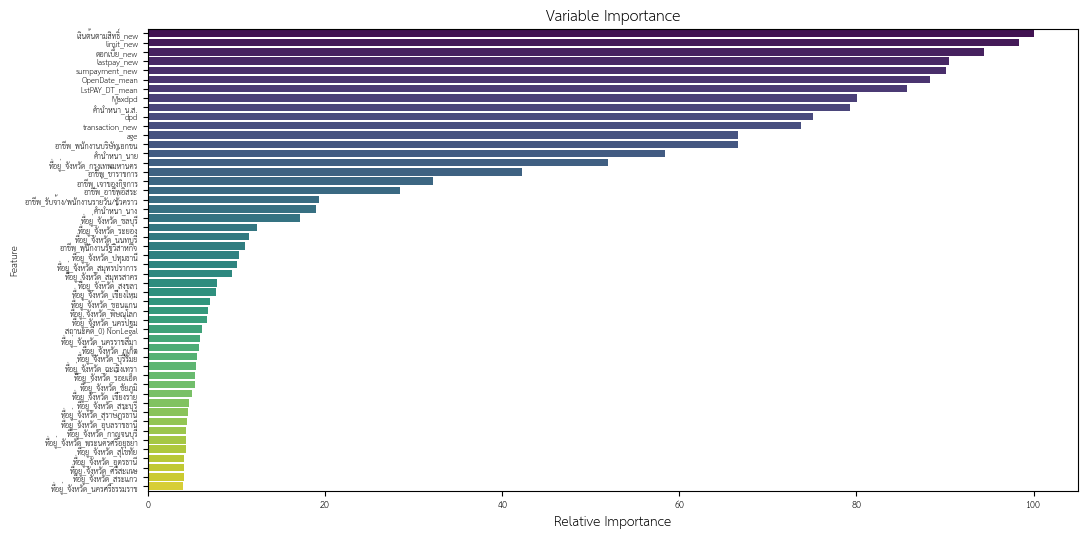

In [62]:
plt.rcParams['font.family'] = 'TH Sarabun New'

# feature importance
feature_importance = RF_model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)  # เรียงลำดับจากน้อยไปมาก
top_n = 50
sorted_idx_top = sorted_idx[-top_n:]  # เลือก 50 อันดับแรก
feature_importance_top = feature_importance[sorted_idx_top]
feature_names_top = X.columns[sorted_idx_top]

# สร้าง DataFrame และเรียงลำดับจากมากไปน้อย
importance_df = pd.DataFrame({
    'Feature': feature_names_top,
    'Importance': feature_importance_top
}).sort_values(by='Importance', ascending=False)  

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')

plt.xlabel('Relative Importance', fontsize=14)
plt.title('Variable Importance', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=8)
plt.show()


In [19]:
XG_model = XGBClassifier()
XG_model.fit(X_train_SMOTE, y_train_SMOTE)
y_pred_XG = XG_model.predict(X_test)
print(accuracy_score(y_test, y_pred_XG))
print(classification_report(y_test, y_pred_XG))
print(confusion_matrix(y_test, y_pred_XG))

0.9392523364485982
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      2629
         1.0       0.30      0.08      0.12       153

    accuracy                           0.94      2782
   macro avg       0.62      0.53      0.55      2782
weighted avg       0.91      0.94      0.92      2782

[[2601   28]
 [ 141   12]]


In [20]:
XGram_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'colsample_bytree': [None, 0.2, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.1, 1, 10],
    'scale_pos_weight': [15, 16, 17, 18, 19]
}
XG_model = XGBClassifier()
with joblib.parallel_backend('dask'):
    XG_grid_search = skGridSearchCV(estimator=XG_model, param_grid=XGram_grid, cv=5, scoring='f1_macro',error_score='raise')
    XG_grid_search.fit(X_train_SMOTE, y_train_SMOTE)
print("Best Parameters for XGClassifier:", XG_grid_search.best_params_)
print("Best Score for XGClassifier:", XG_grid_search.best_score_)
best_params_XG = XG_grid_search.best_params_

2024-10-10 21:22:41,040 - distributed.scheduler - WARNING - Worker failed to heartbeat for 11014s; attempting restart: <WorkerState 'tcp://127.0.0.1:50666', name: 2, status: running, memory: 0, processing: 0>
2024-10-10 21:22:41,172 - distributed.scheduler - WARNING - Worker failed to heartbeat for 11014s; attempting restart: <WorkerState 'tcp://127.0.0.1:50667', name: 0, status: running, memory: 0, processing: 0>
2024-10-10 21:22:41,178 - distributed.scheduler - WARNING - Worker failed to heartbeat for 11014s; attempting restart: <WorkerState 'tcp://127.0.0.1:50672', name: 3, status: running, memory: 0, processing: 0>
2024-10-10 21:22:41,178 - distributed.scheduler - WARNING - Worker failed to heartbeat for 11014s; attempting restart: <WorkerState 'tcp://127.0.0.1:50673', name: 1, status: running, memory: 0, processing: 0>
2024-10-10 21:22:43,085 - distributed.nanny - WARNING - Restarting worker
2024-10-10 21:22:43,092 - distributed.nanny - WARNING - Restarting worker
2024-10-10 21:22

XGBoostError: bad allocation

อาจปรับ X_iso เป็น X_SMOTE ลองดูอีกที

In [ ]:
def evaluate_model(params, X):
    model = IsolationForest(**params)
    model.fit(X)
    # ทำการทำนายค่า
    predictions = model.predict(X)
    # คำนวณค่า score (คุณสามารถใช้วิธีการประเมินอื่นตามต้องการ)
    score = roc_auc_score((predictions == -1).astype(int), [0]*len(X))  # ปรับตามความเหมาะสม
    return score

In [ ]:
IF_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_samples': [0.5, 0.75, 1.0],
    'contamination': [0.1, 0.2, 0.3, 0.4, 0.5],
    'max_features': [1, 2, 3, 4, 5],
    'bootstrap': [True, False],
    'random_state': [42], 
    'max_depth': [None, 5, 10], 
    'warm_start': [True, False], 
    'n_jobs': [-1],
    'novelty': [True],
    'contamination': [0.05, 0.1, 0.15, 0.2, 0.25]
}
best_score_iso = -1
best_params_iso = None
for params in ParameterGrid(IF_param_grid):
    score = evaluate_model(params, X_iso)
    if score > best_score_iso:
        best_score_iso = score
        best_params_iso = params

print("Best parameters found: ", best_params_iso)
print("Best score: ", best_score_iso)